In [1]:
import pandas as pd
import re
import pickle
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, f1_score,\
                            hamming_loss, multilabel_confusion_matrix, precision_score, recall_score
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, PassiveAggressiveClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import chi2
from sklearn.pipeline import Pipeline
from stop_words import get_stop_words
from uk_stemmer import UkStemmer
import tokenize_uk
import matplotlib.pyplot as plt 
from nltk import stem
import pymorphy2
import razdel
import dateparser
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

### Loading news in dataframe

In [20]:
ukr_news_path = '../train_data/combined_ukr_300.csv'
ru_news_path = '../train_data/combined_ru_100.csv'

comb_ukr = pd.read_csv(ukr_news_path)
comb_ru = pd.read_csv(ru_news_path)

### Add automaticaly categorized news to ones categorized by hand

In [6]:
t = comb_ukr[(comb_ukr.part=='Oksana')&(comb_ukr.category=='Світ')&(comb_ukr.text.str.contains('кордон'))]

In [34]:
def add_samples_to_df(from_df, to_df, n_samples=200):
    for cat in from_df.category.unique():
        if (from_df.category==cat).sum() > n_samples-1:
            samp = (from_df[from_df.category==cat]).sample(n_samples)
        else:
            samp = from_df[from_df.category==cat]
        to_df = pd.concat([to_df, samp])

    to_df = to_df.drop_duplicates('link')
    to_df['all_text'] = to_df.title.str.cat(to_df.text, sep='\n')
    return to_df

### Save sample news to file

In [15]:
def get_samples(news, domains = [], sample_size = 20, month=0, lang = '', output_file = '../data/new_samples.csv'):
    news_samples = []
    domains = news.domain.unique() if not domains else domains
    lang_mask = news.lang==lang if lang else True
    period_mask = news.datetime.dt.month>month
    for d in domains:
        news_samples.append(news[(news.domain==d)&period_mask&lang_mask].sample(sample_size))
    news_samples = pd.concat(news_samples)
    news_samples.to_csv(output_file, index=False)
    return news_samples

### Initialization of stop words, stemmer and lemmatizer for ukrainian and russian

In [2]:
stop_words_ukr = get_stop_words('uk')
stop_words_ru = get_stop_words('ru')

additional_sw_ukr_path = '../dicts/more_stop_words_ukr.txt'
additional_sw_ru_path = '../dicts/more_stop_words_ru.txt'

with open(additional_sw_ukr_path) as f:
    more_stopwords_ukr = [w.strip() for w in f.readlines()]
    
with open(additional_sw_ru_path) as f:
    more_stopwords_ru = [w.strip() for w in f.readlines()]
    
stop_words_ukr += more_stopwords_ukr
stop_words_ru += more_stopwords_ru

stemmer_ru = stem.snowball.SnowballStemmer("russian") 
stemmer_ukr = UkStemmer()

stemmed_stopwords_ukr = set([stemmer_ukr.stem_word(word) for word in stop_words_ukr])
stemmed_stopwords_ru = set([stemmer_ru.stem(word) for word in stop_words_ru])

morph_ru = pymorphy2.MorphAnalyzer(lang='ru')
morph_ukr = pymorphy2.MorphAnalyzer(lang='uk')

## Parameters for custom tokenizers for ukrainian an russian

In [3]:
token_pattern = re.compile(r'\w{2,}')

stem_ukr = {"tokenize": tokenize_uk.tokenize_words,
            "stem": stemmer_ukr.stem_word, 
            "stop_words": stemmed_stopwords_ukr,
           "token_pattern": token_pattern}

stem_ru = {"tokenize": lambda text: [_.text for _ in razdel.tokenize(text)],
            "stem": stemmer_ru.stem, 
            "stop_words": stemmed_stopwords_ru,
           "token_pattern": token_pattern}

lemm_ukr = {"tokenize": tokenize_uk.tokenize_words,
            "stem": lambda w: morph_ukr.parse(w)[0].normal_form, 
            "stop_words": stop_words_ukr,
           "token_pattern": token_pattern}

lemm_ru = {"tokenize": lambda text: [_.text for _ in razdel.tokenize(text)],
            "stem": lambda w: morph_ru.parse(w)[0].normal_form, 
            "stop_words": stop_words_ru,
           "token_pattern": token_pattern}

## Functions to split data, get custom tokenizer and features

In [4]:
def split_data(text, label, test_size):
    return train_test_split(text, label, test_size=test_size, stratify = label)


def my_tokenizer(text, tokenize, stem, stop_words, token_pattern):
    tokens = tokenize(text)
    stemmed = [stem(tok) for tok in tokens if ( len(tok)>1 and
                                        token_pattern.match(tok) )]
    return [tok for tok in stemmed if tok not in stop_words]


def get_features(vectorizer, X_train, X_test):
    vectorizer.fit(X_train)
    try:
#         works only for vectorized without lambda
        pickle.dump(vectorizer, open("vectorizer.pkl", "wb"))
    except:
        pass
    X_train = vectorizer.transform(X_train)
    X_test = vectorizer.transform(X_test)
    return X_train, X_test, vectorizer.vocabulary_, vectorizer.get_feature_names()

### Single function to get transformed and oversampled data

In [5]:
def train_test_transform(df, text_col, label_col, tok_params, 
                         max_df=0.9, min_df=3, ngram_range=(1,2), test_size = 0.25):
#     split data
    X_train, X_test, y_train, y_test = split_data(df, df[label_col], test_size)
    
#     initialize vectorizer
    vectorizer = TfidfVectorizer(tokenizer = lambda text: my_tokenizer(text, **tok_params), 
                             max_df=max_df, min_df=min_df, ngram_range=ngram_range)
    
#     transform text
    X_train_vec, X_test_vec, vocabulary, feature_names = get_features(vectorizer, X_train[text_col], X_test[text_col])
    
#     oversample training set (make all categories as big as the largest one)
    oversample = RandomOverSampler()
    X_over, y_over = oversample.fit_resample(X_train_vec, y_train)
    
    return X_train, X_test, X_train_vec, X_test_vec, y_train, y_test, X_over, y_over, feature_names

In [33]:
X_train, X_test, \
X_train_vec, X_test_vec, \
y_train, y_test, X_over, y_over, feature_names = train_test_transform(comb_ukr, 'all_text', 'category', stem_ukr)                                                                    

/Users/oksana/Dev/TextClassification/venv/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


## Check top features for every category

In [6]:
def get_top_features(X_train, y_train, feature_names, N=10):
    for cat in y_train.unique():
        features_chi2 = chi2(X_train, y_train==cat)
        indices = np.argsort(features_chi2[0])
        features = np.array(feature_names)[indices]
        unigrams = [v for v in features if len(v.split(' ')) == 1]
        bigrams = [v for v in features if len(v.split(' ')) == 2]
        print("# '{}':".format(cat))
        print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
        print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

In [180]:
get_top_features(X_train_vec, y_train, feature_names, N=10)

# 'Коронавірус':
  . Most correlated unigrams:
. кількіст
. хвор
. інфікован
. доб
. померл
. пацієнт
. одуж
. covid
. випадк
. коронавірус
# 'Спорт':
  . Most correlated unigrams:
. клуб
. футболіст
. тренер
. команд
. чемпіон
. шахтар
. чемпіонат
. ліг
. динам
. матч
# 'Міжнародна політика':
  . Most correlated unigrams:
. президент
. g7
. вибор
. гонконг
. байден
. трамп
. сша
. лукашенк
. білорус
. санкці
# 'Світ':
  . Most correlated unigrams:
. протестувальник
. принц
. хабаровськ
. землетрус
. протест
. путін
. бейрут
. угорщин
. білорус
. лукашенк
# 'Війна/Донбас':
  . Most correlated unigrams:
. великокаліберн
. кулемет
. вогн
. міномет
. калібр
. оос
. гранатомет
. донбас
. обстріл
. бойовик
# 'Інциденти':
  . Most correlated unigrams:
. кримінальн
. дтп
. зловмисник
. ст
. правоохоронц
. поліц
. чоловік
. інцидент
. вибух
. поліці
# 'Політика':
  . Most correlated unigrams:
. нардеп
. верховн
. політик
. народ
. депутат
. посад
. рад
. порошенк
. зеленськ
. слуг
# 'Карантин'

## Check top word features (general)

In [42]:
feature_array = np.array(feature_names)
tfidf_sorting = np.argsort(X_train_vec.toarray()).flatten()[::-1]
n = 30
feature_array[tfidf_sorting][:n]

array(['океан', 'трагічн', 'чемпіонк', 'смерт', 'загинул', 'спортсменк',
       'човн', 'похід', 'перетнут', 'мертв', 'оголосит', 'змаган', 'світ',
       'фейсбук', 'намагал', 'guardian', 'берег', 'спортсмен', 'відом',
       'унікальн', 'рекорд', 'нагадуєм', 'встановит', 'завершит',
       'страшн', 'загинув', 'хотіл', 'написал', 'the', 'тіл'],
      dtype='<U19')

## Check model accuracy

In [30]:
def test_model(model, X_train, X_test, y_train, y_test, n_splits=4):
    clf = model.fit(X_train, y_train)
    predicted = clf.predict(X_test)
    plot_confusion_matrix(clf, X_test, y_test, xticks_rotation = 'vertical') 
    plt.show() 
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=1)
    cv_score = cross_val_score(model, X_train, y_train, cv=cv, scoring = 'f1_weighted')
    mcv = cv_score.mean()

    print('Weighted f1_score:', f1_score(y_test,predicted, average = 'weighted'))
    print('Micro f1_score:', f1_score(y_test,predicted, average = 'micro'))
    print('Macro f1_score:', f1_score(y_test,predicted, average = 'macro'))
    print('Accuracy:', accuracy_score(y_test,predicted))
    print('Recall:', recall_score(y_test,predicted, average = 'weighted'))
    print('Precision:', precision_score(y_test,predicted, average = 'weighted'))
    print('CV_scores:', cv_score)
    print('Mean cv_score:', mcv)
    return clf, predicted

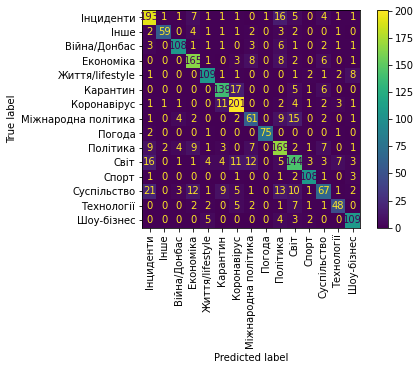

Weighted f1_score: 0.7902115332263605
Micro f1_score: 0.7930411206507004
Macro f1_score: 0.795780803820361
Accuracy: 0.7930411206507004
Recall: 0.7930411206507004
Precision: 0.7914839682412487
CV_scores: [0.80181085 0.78037363 0.78080773 0.79409566]
Mean cv_score: 0.7892719672057992


In [34]:
# test model on original data
model, predicted = test_model(LinearSVC(), X_train_vec, X_test_vec, y_train, y_test)

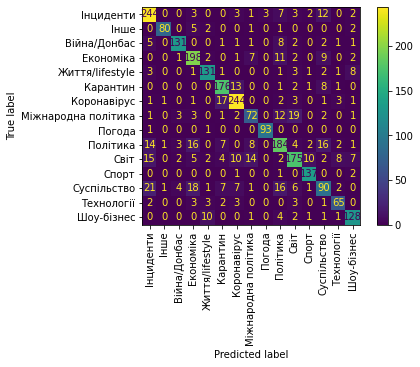

Weighted f1_score: 0.8060285741642668
Micro f1_score: 0.8087349397590361
Macro f1_score: 0.8143518473739302
Accuracy: 0.8087349397590361
Recall: 0.8087349397590361
Precision: 0.8060421280901472
CV_scores: [0.90461759 0.89259236 0.89413335 0.8951176 ]
Mean cv_score: 0.8966152245747304


In [12]:
# test model on oversampled data - ignore CV_score, because there can be same samples in train and test parts
model, predicted = test_model(LinearSVC(), X_over, X_test_vec, y_over, y_test)

### Save misclassified items to file

In [ ]:
mistakes = X_test[y_test != predicted]
mistakes['predicted'] = predicted[y_test != predicted]
mistakes[['category', 'predicted', 'all_text', 'link']].to_csv('../data/misclassified_news.csv')

### Check accuracy by cross validation on whole set

In [54]:
tfidf_stem_ukr = TfidfVectorizer(tokenizer = lambda text: my_tokenizer(text, **stem_ukr), 
                             max_df=0.9, min_df = 3, ngram_range=(1,2))

pipeline = Pipeline([('vectorizer', tfidf_stem_ukr),  ('svc', LinearSVC())])
cv = RepeatedStratifiedKFold(n_splits=4, n_repeats=2)
cv_score = cross_val_score(pipeline, comb_ukr.all_text, comb_ukr.category, cv=cv, scoring='f1_weighted')
cv_score.mean()

0.7827218949908926

## Find best model parameters with GridSearchCV

In [155]:
parameters = {'criterion':['gini', 'entropy'], 'max_features':['auto', 'sqrt', 'log2']}
svc = RandomForestClassifier()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train_vec, y_train)
clf.best_params_

{'criterion': 'gini', 'max_features': 'sqrt'}

### Other variations for data transformation

In [7]:
# to be able to pickle vectorizer you need to get rid of lambda
# i didn't find a better way than defining two separate tokenizers for ukrainian and russian

def tokenizer_ukr(text, tokenize=tokenize_uk.tokenize_words, 
                  stem=stemmer_ukr.stem_word, stop_words=stemmed_stopwords_ukr, token_pattern=token_pattern):
    tokens = tokenize(text)
    stemmed = [stem(tok) for tok in tokens if ( len(tok)>1 and
                                        token_pattern.match(tok) )]
    return [tok for tok in stemmed if tok not in stop_words]


def tokenizer_ru(text, tokenize=lambda text: [_.text for _ in razdel.tokenize(text)], 
                 stem=stemmer_ru.stem, stop_words=stemmed_stopwords_ru, token_pattern=token_pattern):
    tokens = tokenize(text)
    stemmed = [stem(tok) for tok in tokens if ( len(tok)>1 and
                                        token_pattern.match(tok) )]
    return [tok for tok in stemmed if tok not in stop_words]

# now you can fit and save to file
tfidf_stem_ru = TfidfVectorizer(tokenizer = tokenizer_ru, 
                             max_df=0.9, min_df = 3, ngram_range=(1,2))
tfidf_stem_ukr = TfidfVectorizer(tokenizer = tokenizer_ukr, 
                             max_df=0.9, min_df = 3, ngram_range=(1,2))


# ukr_stem_vec = tfidf_stem_ukr.fit_transform(comb_ukr.all_text)
# pickle.dump(tfidf_stem_ukr, open("vectorizer_ukr.pkl", "wb"))
# pickle.dump(ukr_stem_vec, open("transformed_text_ukr.pkl", "wb"))

In [ ]:
clf = LinearSVC()
clf.fit(ukr_stem_vec, comb_ukr.category)
pickle.dump(clf, open("SVC_ukr.pkl", "wb"))

In [37]:
# option with pipeline - to be able to use directly with text
pipeline = Pipeline(steps=[('vectorizer', tfidf_stem_ru), ('svc', LinearSVC())])
pipeline.fit(comb_ru.all_text, comb_ru.category)

# save model to file
pickle.dump(pipeline, open("classification_models/pipeline_ru.pkl", "wb"))

### Loading trained model 

In [10]:
filepath = '../data/summer.csv'
news = pd.read_csv(filepath, index_col=0)
news['all_text'] = news.title.str.cat(news.subtitle, sep='\n', na_rep='')
news['all_text'] = news.all_text.str.cat(news.text, sep='\n', na_rep='')
news['all_text'] = news.all_text.str.strip()
print(news['all_text'].isna().sum())

/Users/oksana/Dev/TextClassification/venv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


0


In [11]:
news = news[(news.language=='uk')|(news.language=='ru')]
print(news.shape)
print(news.language.value_counts())

(477257, 18)
uk    394860
ru     82397
Name: language, dtype: int64


In [8]:
# %%time

# pipeline option

model_ukr = pickle.load(open("classification_models/pipeline_ukr.pkl", "rb"))
model_ru = pickle.load(open("classification_models/pipeline_ru.pkl", "rb"))

# predicted = model.predict(news[news.lang=='uk'].all_text)

/Users/oksana/Dev/TextClassification/venv/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/oksana/Dev/TextClassification/venv/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/oksana/Dev/TextClassification/venv/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LinearSVC from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/oksana/Dev/TextClassification/venv/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Pipeline from 

In [14]:
%%time
predicted_uk = model_ukr.predict(news[news.language=='uk'].all_text)
predicted_ru = model_ru.predict(news[news.language=='ru'].all_text)

CPU times: user 1h 4min 14s, sys: 25.8 s, total: 1h 4min 40s
Wall time: 1h 5min 17s


In [15]:
news['mycategory'] = None

In [ ]:
news.loc[news.language=='uk', 'language'] = predicted_uk
news.loc[news.language=='ru', 'language'] = predicted_ru

In [17]:
news_uk.mycategory = predicted_uk
news_ru.mycategory = predicted_ru

In [18]:
news = pd.concat([news_uk, news_ru])
news.shape

(477257, 19)

In [20]:
news.mycategory = news.mycategory.str.replace('Міжнародна політика', 'Закордонна політика')

In [21]:
news.mycategory.value_counts()

Інциденти              72018
Політика               53586
Економіка              45103
Світ                   44981
Спорт                  42713
Шоу-бізнес             39225
Суспільство            37840
Закордонна політика    32285
Коронавірус            31004
Життя/lifestyle        30730
Технології             16475
Війна/Донбас           14725
Погода                  9652
Карантин                4314
Інше                    2606
Name: mycategory, dtype: int64

In [24]:
news = news.drop(columns=['all_text'])
news.to_csv(filepath)

Index(['id', 'title', 'text', 'subtitle', 'link', 'domain', 'datetime',
       'views', 'created_at', 'category', 'language', 'pub_type', 'author',
       'tags', 'source', 'author_title', 'domain_alias', 'all_text',
       'mycategory'],
      dtype='object')

In [ ]:
'''or two steps'''

# model = pickle.load(open('SVC_ukr.pkl', 'rb'))
# tfidf = pickle.load(open("vectorizer_ukr.pkl", "rb"))

# transformed = tfidf.transform(news[news.language=='uk'].all_text)
# predicted = model.predict(transformed)

### Save top categories to file for the website

In [31]:
# змінювати відповідно до місяця - включати закордонну політику замість шоубізу, якщо йде вона наступна
top_categories = ['Інциденти', 'Політика', 'Світ', 'Економіка', 'Закордонна політика']

In [32]:
top_news = news[news.mycategory.isin(top_categories)]

In [33]:
top_categories_filepath = 'category_all_05_2021.csv'
top_news.groupby('mycategory').domain_alias.value_counts().unstack().reindex(top_categories).to_csv(top_categories_filepath, sep=';')
